In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

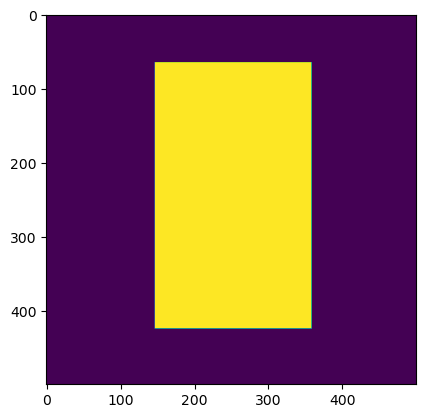

In [3]:
blueprint_tshirt = cv2.imread('blueprints/tshirt_base.png', cv2.IMREAD_GRAYSCALE)
blueprint_shirt = cv2.imread('blueprints/jacket_shirt_base.png', cv2.IMREAD_GRAYSCALE)
blueprint_rect = cv2.imread('blueprints/rect_base.png', cv2.IMREAD_GRAYSCALE)
blueprint_elliptic = cv2.imread('blueprints/elliptic_base.png', cv2.IMREAD_GRAYSCALE)
# Threshold to create a binary mask
_, blueprint_mask_tshirt = cv2.threshold(blueprint_tshirt, 128, 255, cv2.THRESH_BINARY)
_, blueprint_mask_shirt = cv2.threshold(blueprint_shirt, 128, 255, cv2.THRESH_BINARY)
_, blueprint_mask_base = cv2.threshold(blueprint_rect, 128, 255, cv2.THRESH_BINARY)
_, blueprint_mask_elliptic = cv2.threshold(blueprint_elliptic, 128, 255, cv2.THRESH_BINARY)
blueprint_masks = [['large_rect', blueprint_mask_base]]

plt.imshow(blueprint_mask_base)

In [ ]:
rotated_masks = []
angle_step = 10
for angle in range(0, 360, angle_step):
    (h, w) = cropped_mask.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(cropped_mask, M, (w, h), flags=cv2.INTER_NEAREST)
    rotated_masks.append(rotated)

In [ ]:
def compute_overlap(mask1, mask2):
    # Compute the overlapping area between two binary masks
    overlap = np.sum((mask1 == 255) & (mask2 == 255))
    return overlap

def find_best_rotation(input_mask, blueprint_mask, angle_step=1):
    best_angle = 0
    max_overlap = 0
    
    for angle in range(0, 360, angle_step):
        # Rotate the input mask
        rotated_mask = rotate_image(input_mask, angle)
        
        # Compute the overlap with the blueprint mask
        overlap = compute_overlap(rotated_mask, blueprint_mask[1])
        if overlap > max_overlap:
            max_overlap = overlap
            best_angle = angle
    
    #print(f"Best mask: {blueprint_mask[0]}")
    return [max_overlap, best_angle]

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST)
    return rotated



def plot_before_after_rotations(rotated_masks, original_image, num_rows=18):
    fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 3))
    plt.subplots_adjust(hspace=0.0, wspace=0.0)  # Reduce padding between subplots

    for i in range(num_rows):
        line_ax = fig.add_subplot(num_rows, 1, i + 1, frame_on=False)
        line_ax.plot([0.5, 0.5], [0, 1], transform=fig.transFigure, color='red', linestyle='--')
        line_ax.axis('off')  # Turn off the axis

    for i, mask in enumerate(rotated_masks):
        # Find the best rotation angle
        tester = rotate_image(original_image, i * 10)
        angles = []
        for blueprint_mask in blueprint_masks:
            best_angle = find_best_rotation(mask, blueprint_mask)
            angles.append(best_angle)
        best_angle_final = np.max(angles, axis=0)[1]

        aligned_image = rotate_image(tester, best_angle_final)
        
        row = i // 2
        col = (i % 2) * 2
        
        axs[row, col].imshow(tester, cmap='gray')
        axs[row, col].set_title(f'Before Rotation {i*10}°')
        axs[row, col].axis('off')

        axs[row, col + 1].imshow(aligned_image, cmap='gray')
        axs[row, col + 1].set_title(f'After Best Rotation {best_angle_final}°')
        axs[row, col + 1].axis('off')

    plt.tight_layout()
    plt.savefig(f'./plots/{file_name}')


plot_before_after_rotations(rotated_masks, masked_image)

